1. Training Data Analysis
1.1 Dataset Overview & Structure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

# Load and examine basic structure
train_df = pd.read_csv('/kaggle/input/make-data-count-finding-data-references/train_labels.csv')
print("Dataset Shape:", train_df.shape)
print("\nColumns:", train_df.columns.tolist())
print("\nData Types:")
print(train_df.dtypes)
print("\nFirst few rows:")
print(train_df.head())

Dataset Shape: (1028, 3)

Columns: ['article_id', 'dataset_id', 'type']

Data Types:
article_id    object
dataset_id    object
type          object
dtype: object

First few rows:
               article_id                      dataset_id     type
0    10.1002_2017jc013030  https://doi.org/10.17882/49388  Primary
1  10.1002_anie.201916483                         Missing  Missing
2  10.1002_anie.202005531                         Missing  Missing
3  10.1002_anie.202007717                         Missing  Missing
4  10.1002_chem.201902131                         Missing  Missing


1.2 Label Distribution Analysis


Citation Type Distribution:
type
Secondary    449
Missing      309
Primary      270
Name: count, dtype: int64

Primary vs Secondary Ratio: 0.60


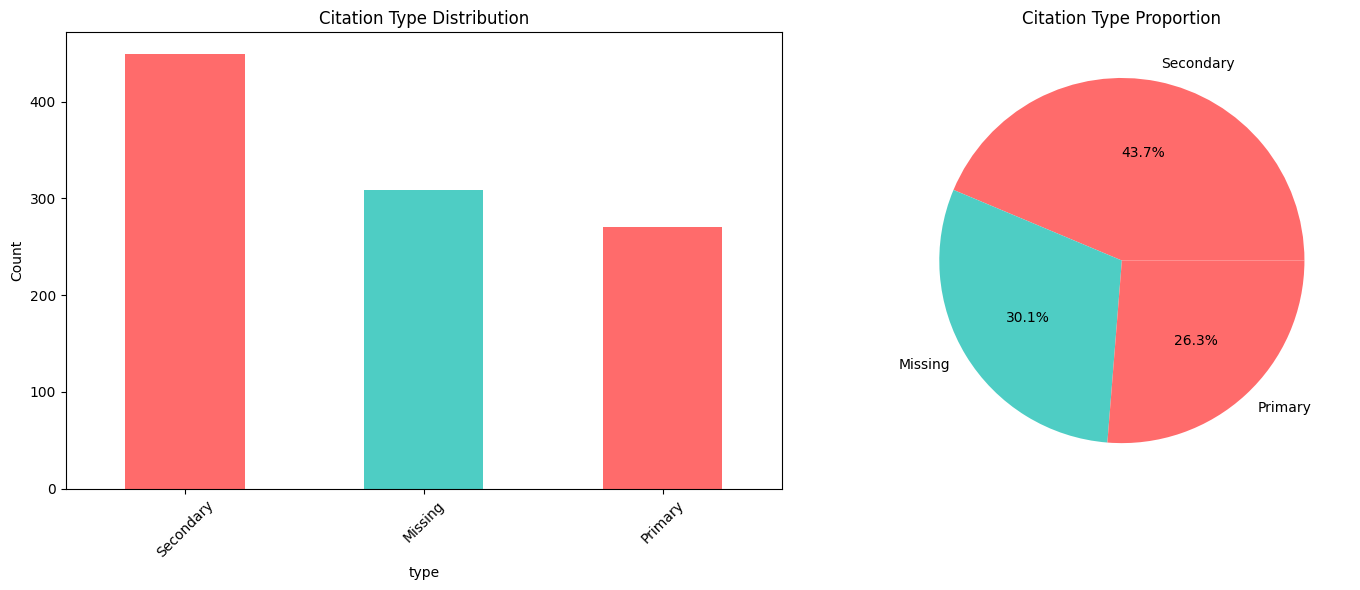

In [2]:
# Citation type distribution
type_counts = train_df['type'].value_counts()
print("Citation Type Distribution:")
print(type_counts)
print(f"\nPrimary vs Secondary Ratio: {type_counts['Primary']/type_counts['Secondary']:.2f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
type_counts.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Citation Type Distribution')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
        colors=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Citation Type Proportion')

plt.tight_layout()
plt.show()

1.3 Article-Level Analysis

Articles Citation Statistics:
Total unique articles: 523
Mean citations per article: 1.97
Median citations per article: 1.00
Max citations in single article: 32


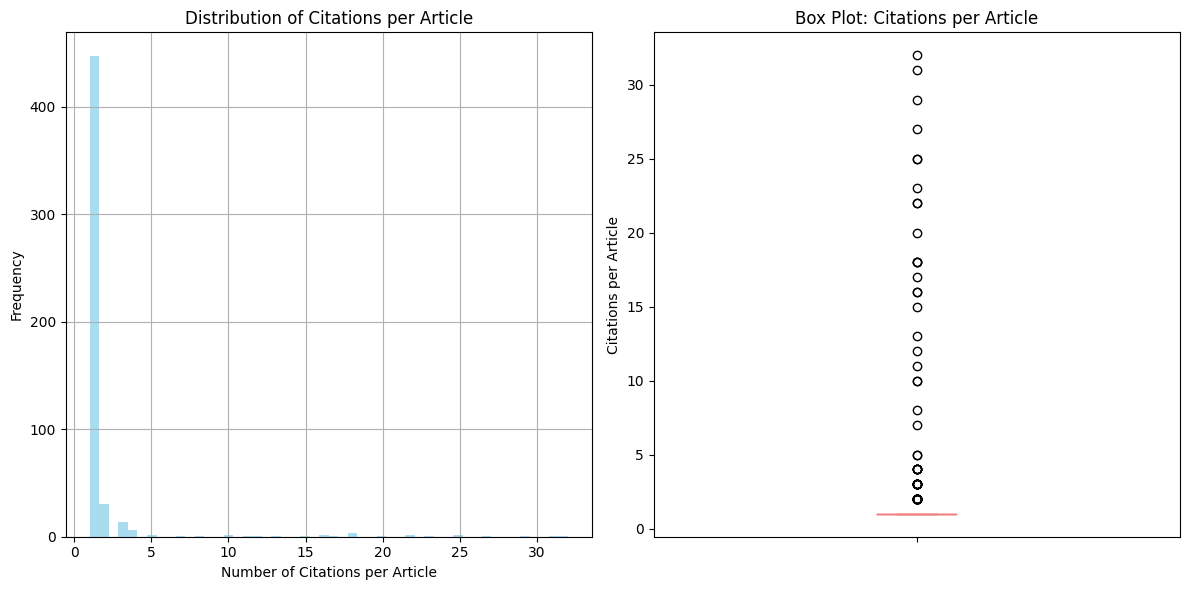


Top 10 Articles by Citation Count:
article_id
10.3390_v11060565               32
10.1038_s41396-020-00885-8      31
10.1128_spectrum.00422-24       29
10.1371_journal.pone.0159387    27
10.1371_journal.pone.0212669    25
10.7717_peerj.10452             25
10.1111_cas.12935               23
10.1128_JVI.01717-21            22
10.1371_journal.pcbi.1011828    22
10.1038_s41598-020-59839-x      20
dtype: int64


In [3]:
# Articles per citation analysis
articles_per_citation = train_df.groupby('article_id').size()
print("Articles Citation Statistics:")
print(f"Total unique articles: {train_df['article_id'].nunique()}")
print(f"Mean citations per article: {articles_per_citation.mean():.2f}")
print(f"Median citations per article: {articles_per_citation.median():.2f}")
print(f"Max citations in single article: {articles_per_citation.max()}")

# Distribution of citations per article
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
articles_per_citation.hist(bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Number of Citations per Article')
plt.ylabel('Frequency')
plt.title('Distribution of Citations per Article')

plt.subplot(1, 2, 2)
articles_per_citation.plot(kind='box', color='lightcoral')
plt.ylabel('Citations per Article')
plt.title('Box Plot: Citations per Article')

plt.tight_layout()
plt.show()

# Top articles by citation count
top_articles = articles_per_citation.nlargest(10)
print("\nTop 10 Articles by Citation Count:")
print(top_articles)

1.4 Dataset ID Pattern Analysis

Dataset ID Patterns:
DOI: 325 (31.6%)
Dryad: 79 (7.7%)
CHEMBL: 29 (2.8%)
Zenodo: 22 (2.1%)
GitHub: 0 (0.0%)
FigShare: 0 (0.0%)
GenBank: 0 (0.0%)
PDB: 0 (0.0%)
UniProt: 0 (0.0%)
Kaggle: 0 (0.0%)


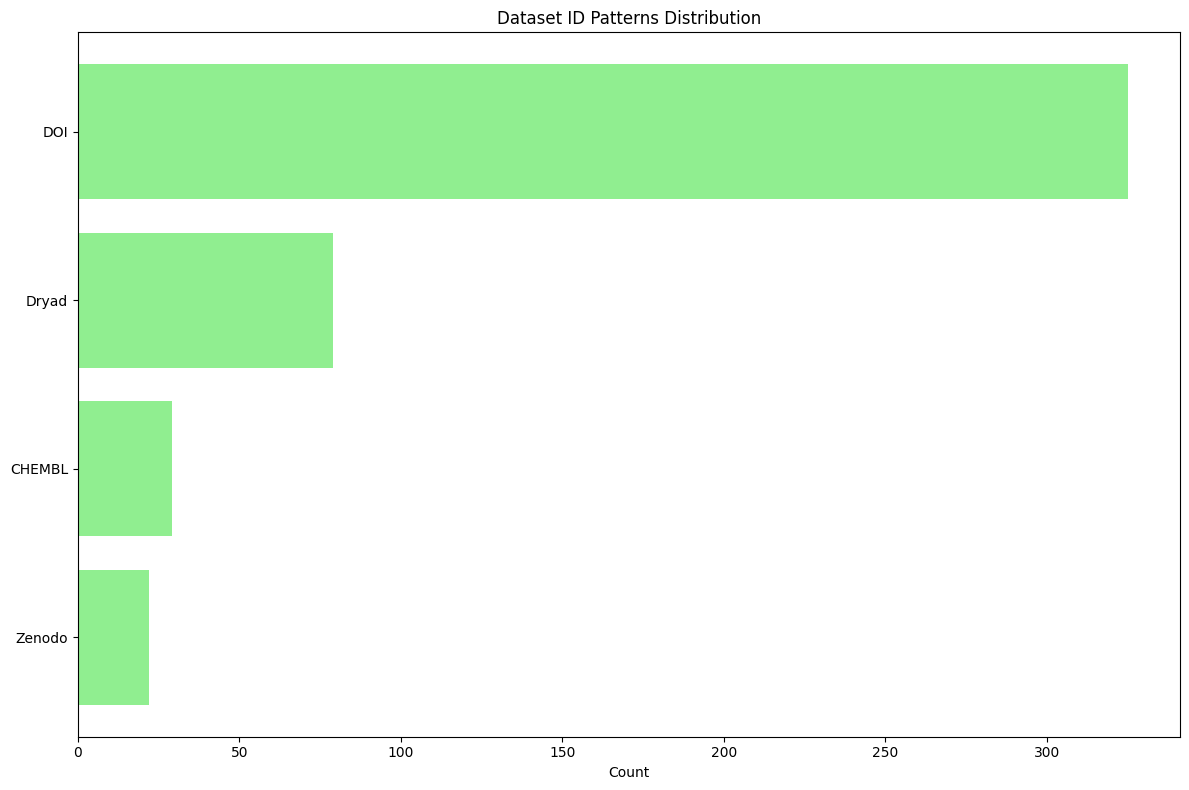

In [4]:
# Dataset ID patterns and types
dataset_patterns = {
    'DOI': r'https://doi\.org/',
    'Zenodo': r'zenodo',
    'GitHub': r'github',
    'FigShare': r'figshare',
    'Dryad': r'dryad',
    'GenBank': r'genbank|ncbi',
    'PDB': r'pdb|rcsb',
    'CHEMBL': r'chembl',
    'UniProt': r'uniprot',
    'Kaggle': r'kaggle'
}

pattern_counts = {}
for pattern_name, pattern in dataset_patterns.items():
    count = train_df['dataset_id'].str.contains(pattern, case=False, na=False).sum()
    pattern_counts[pattern_name] = count

print("Dataset ID Patterns:")
for pattern, count in sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{pattern}: {count} ({count/len(train_df)*100:.1f}%)")

# Visualize dataset patterns
plt.figure(figsize=(12, 8))
patterns_df = pd.DataFrame(list(pattern_counts.items()), columns=['Pattern', 'Count'])
patterns_df = patterns_df[patterns_df['Count'] > 0].sort_values('Count', ascending=True)

plt.barh(patterns_df['Pattern'], patterns_df['Count'], color='lightgreen')
plt.xlabel('Count')
plt.title('Dataset ID Patterns Distribution')
plt.tight_layout()
plt.show()

1.5 Edge Cases & Anomalies Detection

In [5]:
# Identify potential edge cases
print("=== EDGE CASES ANALYSIS ===")

# 1. Unusual dataset_id formats
print("1. Dataset ID Length Distribution:")
id_lengths = train_df['dataset_id'].str.len()
print(f"Mean length: {id_lengths.mean():.1f}")
print(f"Min length: {id_lengths.min()}")
print(f"Max length: {id_lengths.max()}")

# Very short or very long IDs
short_ids = train_df[id_lengths < 10]['dataset_id'].unique()
long_ids = train_df[id_lengths > 100]['dataset_id'].unique()
print(f"\nVery short IDs (<10 chars): {len(short_ids)}")
print(f"Very long IDs (>100 chars): {len(long_ids)}")

# 2. Duplicate detection
duplicates = train_df.duplicated(subset=['article_id', 'dataset_id', 'type'])
print(f"\n2. Exact duplicates: {duplicates.sum()}")

# 3. Same dataset_id with different types in same article
same_data_diff_type = train_df.groupby(['article_id', 'dataset_id'])['type'].nunique()
conflicting = same_data_diff_type[same_data_diff_type > 1]
print(f"\n3. Same dataset with different types in same article: {len(conflicting)}")

# 4. Missing or malformed DOIs
doi_pattern = r'https://doi\.org/10\.\d+/.+'
valid_dois = train_df['dataset_id'].str.match(doi_pattern, na=False)
malformed_dois = train_df[train_df['dataset_id'].str.contains('doi', case=False, na=False) & ~valid_dois]
print(f"\n4. Potentially malformed DOIs: {len(malformed_dois)}")

=== EDGE CASES ANALYSIS ===
1. Dataset ID Length Distribution:
Mean length: 18.1
Min length: 4
Max length: 62

Very short IDs (<10 chars): 154
Very long IDs (>100 chars): 0

2. Exact duplicates: 0

3. Same dataset with different types in same article: 0

4. Potentially malformed DOIs: 0


## 2. Text Corpus Exploration

### 2.1 Document Structure Analysis


In [6]:
def analyze_document_structure(text_data):
    """Analyze the structure of scientific papers"""
    
    # Common section headers in scientific papers
    section_patterns = {
        'Abstract': r'\babstract\b',
        'Introduction': r'\bintroduction\b',
        'Methods': r'\bmethods?\b|\bmethodology\b',
        'Results': r'\bresults?\b',
        'Discussion': r'\bdiscussion\b',
        'Conclusion': r'\bconclusion\b',
        'References': r'\breferences?\b|\bbibliography\b',
        'Acknowledgments': r'\backnowledg',
        'Appendix': r'\bappendix\b|\bsupplementary\b'
    }
    
    structure_stats = {}
    for section, pattern in section_patterns.items():
        matches = text_data.str.contains(pattern, case=False, na=False).sum()
        structure_stats[section] = matches
    
    return structure_stats

# If you have full text data:
# structure_stats = analyze_document_structure(full_text_df['text'])
# print("Document Structure Analysis:")
# for section, count in structure_stats.items():
#     print(f"{section}: {count} documents ({count/len(full_text_df)*100:.1f}%)")

2.2 Citation Pattern Analysis


In [7]:
# Analyze citation patterns in dataset_ids
def analyze_citation_patterns(dataset_ids):
    """Analyze common patterns in how data is cited"""
    
    patterns = {
        'URL_with_DOI': r'https://doi\.org/',
        'Direct_URL': r'https?://(?!doi\.org)',
        'Repository_ID': r'^[A-Z]+\d+$',
        'Accession_Number': r'^[A-Z]{2,}_?\d+',
        'File_Path': r'[/\\]',
        'Version_Number': r'v\d+|version\s*\d+',
        'Date_Pattern': r'\d{4}[-/]\d{2}[-/]\d{2}',
    }
    
    pattern_analysis = {}
    for pattern_name, pattern in patterns.items():
        matches = dataset_ids.str.contains(pattern, case=False, na=False, regex=True).sum()
        pattern_analysis[pattern_name] = {
            'count': matches,
            'percentage': matches / len(dataset_ids) * 100,
            'examples': dataset_ids[dataset_ids.str.contains(pattern, case=False, na=False, regex=True)].head(3).tolist()
        }
    
    return pattern_analysis

citation_patterns = analyze_citation_patterns(train_df['dataset_id'])
print("Citation Pattern Analysis:")
for pattern, stats in citation_patterns.items():
    print(f"\n{pattern}:")
    print(f"  Count: {stats['count']} ({stats['percentage']:.1f}%)")
    print(f"  Examples: {stats['examples']}")

Citation Pattern Analysis:

URL_with_DOI:
  Count: 325 (31.6%)
  Examples: ['https://doi.org/10.17882/49388', 'https://doi.org/10.5061/dryad.r6nq870', 'https://doi.org/10.5061/dryad.2f62927']

Direct_URL:
  Count: 0 (0.0%)
  Examples: []

Repository_ID:
  Count: 272 (26.5%)
  Examples: ['CHEMBL1097', 'CHEMBL1257578', 'CHEMBL1257821']

Accession_Number:
  Count: 256 (24.9%)
  Examples: ['CHEMBL1097', 'CHEMBL1257578', 'CHEMBL1257821']

File_Path:
  Count: 325 (31.6%)
  Examples: ['https://doi.org/10.17882/49388', 'https://doi.org/10.5061/dryad.r6nq870', 'https://doi.org/10.5061/dryad.2f62927']

Version_Number:
  Count: 37 (3.6%)
  Examples: ['https://doi.org/10.17862/cranfield.rd.19146182.v1', 'https://doi.org/10.11583/dtu.20555586.v3', 'https://doi.org/10.23642/usn.15134442.v1']

Date_Pattern:
  Count: 0 (0.0%)
  Examples: []


2.3 Linguistic Analysis

Top 15 Data Repository Domains:
doi.org: 325


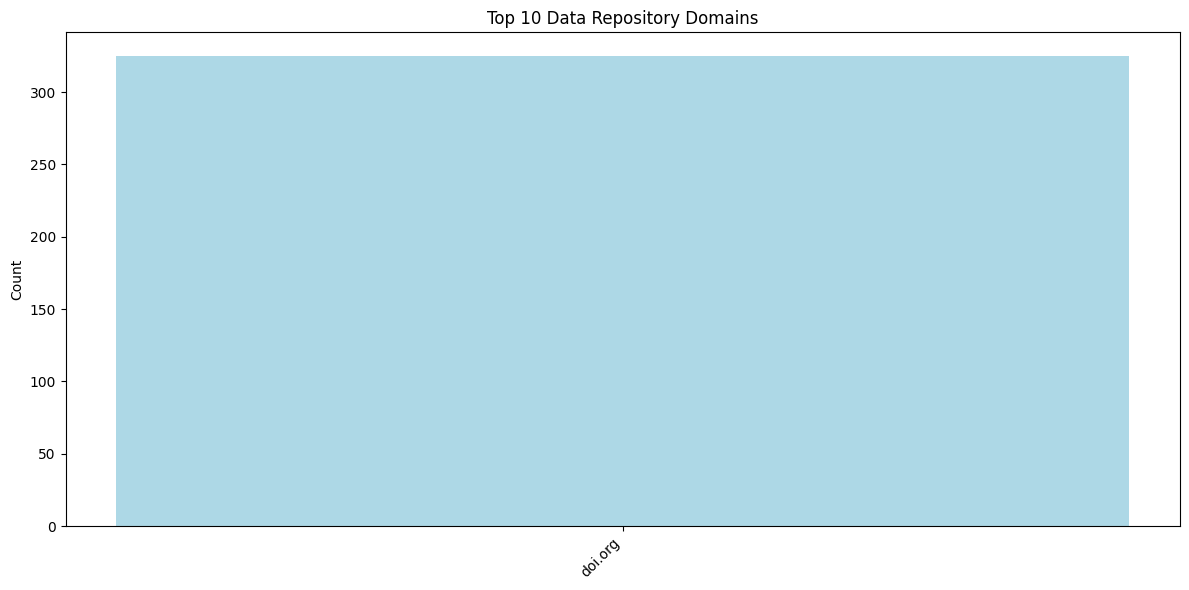

In [8]:
# Repository and domain analysis
def extract_domains_and_repositories(dataset_ids):
    """Extract domains and repositories from dataset IDs"""
    
    # Extract domains from URLs
    url_pattern = r'https?://([^/]+)'
    domains = []
    
    for dataset_id in dataset_ids:
        if pd.isna(dataset_id):
            continue
        match = re.search(url_pattern, str(dataset_id))
        if match:
            domains.append(match.group(1))
    
    return Counter(domains)

domains = extract_domains_and_repositories(train_df['dataset_id'])
print("Top 15 Data Repository Domains:")
for domain, count in domains.most_common(15):
    print(f"{domain}: {count}")

# Visualize top domains
if domains:
    top_domains = dict(domains.most_common(10))
    plt.figure(figsize=(12, 6))
    plt.bar(top_domains.keys(), top_domains.values(), color='lightblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('Top 10 Data Repository Domains')
    plt.tight_layout()
    plt.show()

3. Baseline Establishment
3.1 Simple Regex/Rule-Based Approach


In [9]:
import re
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

class DataCitationBaseline:
    def __init__(self):
        # Define patterns that might indicate primary vs secondary data
        self.primary_patterns = [
            r'generated.{0,20}(for|in).{0,20}(this|current|present).{0,20}study',
            r'collected.{0,20}(for|in).{0,20}(this|current|present).{0,20}(study|work|research)',
            r'our.{0,20}(data|dataset|measurements)',
            r'newly.{0,20}(generated|collected|acquired)',
            r'specifically.{0,20}(generated|collected|created)',
            r'(raw|processed).{0,20}data.{0,20}(generated|collected|produced)',
        ]
        
        self.secondary_patterns = [
            r'(obtained|downloaded|retrieved|accessed).{0,20}from',
            r'(available|accessible).{0,20}(at|from)',
            r'(public|publicly).{0,20}available',
            r'(previously|earlier).{0,20}(published|reported)',
            r'(existing|published).{0,20}(data|dataset)',
            r'(reused|re-used).{0,20}(data|dataset)',
            r'(database|repository|archive)',
        ]
    
    def predict_citation_type(self, text_context):
        """
        Predict citation type based on textual context
        Returns 'Primary' or 'Secondary'
        """
        if pd.isna(text_context):
            return 'Secondary'  # Default assumption
        
        text_lower = str(text_context).lower()
        
        primary_score = sum(1 for pattern in self.primary_patterns 
                          if re.search(pattern, text_lower, re.IGNORECASE))
        secondary_score = sum(1 for pattern in self.secondary_patterns 
                            if re.search(pattern, text_lower, re.IGNORECASE))
        
        if primary_score > secondary_score:
            return 'Primary'
        elif secondary_score > primary_score:
            return 'Secondary'
        else:
            # If tie or no matches, use dataset_id patterns
            return self.predict_from_dataset_id(text_context)
    
    def predict_from_dataset_id(self, dataset_id):
        """Predict based on dataset_id patterns"""
        if pd.isna(dataset_id):
            return 'Secondary'
        
        dataset_id_str = str(dataset_id).lower()
        
        # Patterns that suggest primary data
        if any(pattern in dataset_id_str for pattern in ['zenodo', 'figshare', 'dryad']):
            return 'Primary'
        
        # Patterns that suggest secondary data
        if any(pattern in dataset_id_str for pattern in ['ncbi', 'genbank', 'uniprot', 'pdb']):
            return 'Secondary'
        
        return 'Secondary'  # Default

# Initialize baseline model
baseline_model = DataCitationBaseline()

# For demonstration, let's create a simple evaluation
# Note: You'll need to adapt this based on your actual text data structure
def evaluate_baseline(train_df, baseline_model):
    """Evaluate the baseline model"""
    
    # For this example, we'll use dataset_id as proxy for text context
    # In practice, you'd use the actual paper text around citations
    predictions = train_df['dataset_id'].apply(baseline_model.predict_from_dataset_id)
    
    # Calculate metrics
    f1 = f1_score(train_df['type'], predictions, average='weighted')
    precision = precision_score(train_df['type'], predictions, average='weighted')
    recall = recall_score(train_df['type'], predictions, average='weighted')
    
    print("Baseline Model Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(train_df['type'], predictions))
    
    return predictions

# Run baseline evaluation
baseline_predictions = evaluate_baseline(train_df, baseline_model)

Baseline Model Performance:
F1 Score: 0.4260
Precision: 0.4711
Recall: 0.5331

Detailed Classification Report:
              precision    recall  f1-score   support

     Missing       0.00      0.00      0.00       309
     Primary       0.99      0.37      0.54       270
   Secondary       0.48      1.00      0.65       449

    accuracy                           0.53      1028
   macro avg       0.49      0.46      0.40      1028
weighted avg       0.47      0.53      0.43      1028



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

3.2 Feature Engineering Ideas


In [10]:
def extract_features(row):
    """Extract features for ML models"""
    features = {}
    
    dataset_id = str(row['dataset_id']) if pd.notna(row['dataset_id']) else ''
    
    # URL-based features
    features['is_doi'] = 'doi.org' in dataset_id.lower()
    features['is_zenodo'] = 'zenodo' in dataset_id.lower()
    features['is_github'] = 'github' in dataset_id.lower()
    features['is_figshare'] = 'figshare' in dataset_id.lower()
    features['is_ncbi'] = any(x in dataset_id.lower() for x in ['ncbi', 'genbank'])
    features['is_uniprot'] = 'uniprot' in dataset_id.lower()
    features['is_pdb'] = 'pdb' in dataset_id.lower()
    
    # ID structure features
    features['id_length'] = len(dataset_id)
    features['has_version'] = bool(re.search(r'v\d+|version', dataset_id, re.IGNORECASE))
    features['has_date'] = bool(re.search(r'\d{4}', dataset_id))
    features['num_slashes'] = dataset_id.count('/')
    features['num_dots'] = dataset_id.count('.')
    
    # Repository type features
    repository_types = {
        'general_repo': ['zenodo', 'figshare', 'dryad', 'osf'],
        'bio_repo': ['ncbi', 'genbank', 'uniprot', 'pdb', 'ensembl'],
        'chem_repo': ['chembl', 'pubchem'],
        'code_repo': ['github', 'gitlab', 'bitbucket'],
        'institutional': ['.edu', '.gov', '.org']
    }
    
    for repo_type, keywords in repository_types.items():
        features[f'is_{repo_type}'] = any(kw in dataset_id.lower() for kw in keywords)
    
    return features

# Extract features for a sample
sample_features = train_df.apply(extract_features, axis=1)
features_df = pd.DataFrame(sample_features.tolist())
print("Feature Engineering Preview:")
print(features_df.head())
print(f"\nTotal features extracted: {len(features_df.columns)}")

Feature Engineering Preview:
   is_doi  is_zenodo  is_github  is_figshare  is_ncbi  is_uniprot  is_pdb  \
0    True      False      False        False    False       False   False   
1   False      False      False        False    False       False   False   
2   False      False      False        False    False       False   False   
3   False      False      False        False    False       False   False   
4   False      False      False        False    False       False   False   

   id_length  has_version  has_date  num_slashes  num_dots  is_general_repo  \
0         30        False      True            4         2            False   
1          7        False     False            0         0            False   
2          7        False     False            0         0            False   
3          7        False     False            0         0            False   
4          7        False     False            0         0            False   

   is_bio_repo  is_chem_repo  is_

4. Advanced Analysis & Insights

.1 Citation Network Analysis


In [11]:
# Analyze relationships between articles and datasets
def build_citation_network(train_df):
    """Build a network of citations between articles and datasets"""
    
    # Article-Dataset relationships
    article_dataset_pairs = train_df.groupby(['article_id', 'dataset_id']).size().reset_index(name='count')
    
    # Datasets cited by multiple articles
    dataset_popularity = train_df.groupby('dataset_id')['article_id'].nunique().sort_values(ascending=False)
    popular_datasets = dataset_popularity[dataset_popularity > 1]
    
    print(f"Datasets cited by multiple articles: {len(popular_datasets)}")
    print("Top 10 most cited datasets:")
    print(popular_datasets.head(10))
    
    # Articles citing multiple datasets
    article_diversity = train_df.groupby('article_id')['dataset_id'].nunique().sort_values(ascending=False)
    diverse_articles = article_diversity[article_diversity > 5]
    
    print(f"\nArticles citing 5+ datasets: {len(diverse_articles)}")
    print("Top 10 articles by dataset diversity:")
    print(diverse_articles.head(10))
    
    return article_dataset_pairs, popular_datasets, diverse_articles

network_data = build_citation_network(train_df)

Datasets cited by multiple articles: 1
Top 10 most cited datasets:
dataset_id
Missing    309
Name: article_id, dtype: int64

Articles citing 5+ datasets: 24
Top 10 articles by dataset diversity:
article_id
10.3390_v11060565               32
10.1038_s41396-020-00885-8      31
10.1128_spectrum.00422-24       29
10.1371_journal.pone.0159387    27
10.1371_journal.pone.0212669    25
10.7717_peerj.10452             25
10.1111_cas.12935               23
10.1371_journal.pcbi.1011828    22
10.1128_JVI.01717-21            22
10.1038_s41598-020-59839-x      20
Name: dataset_id, dtype: int64


4.2 Temporal and Domain Analysis


Temporal Analysis of Citations:
type            Primary  Secondary
extracted_year                    
2015.0                0          2
2016.0                0          2
2017.0                0          4
2018.0                0          1
2019.0                0          3
2020.0                1          0


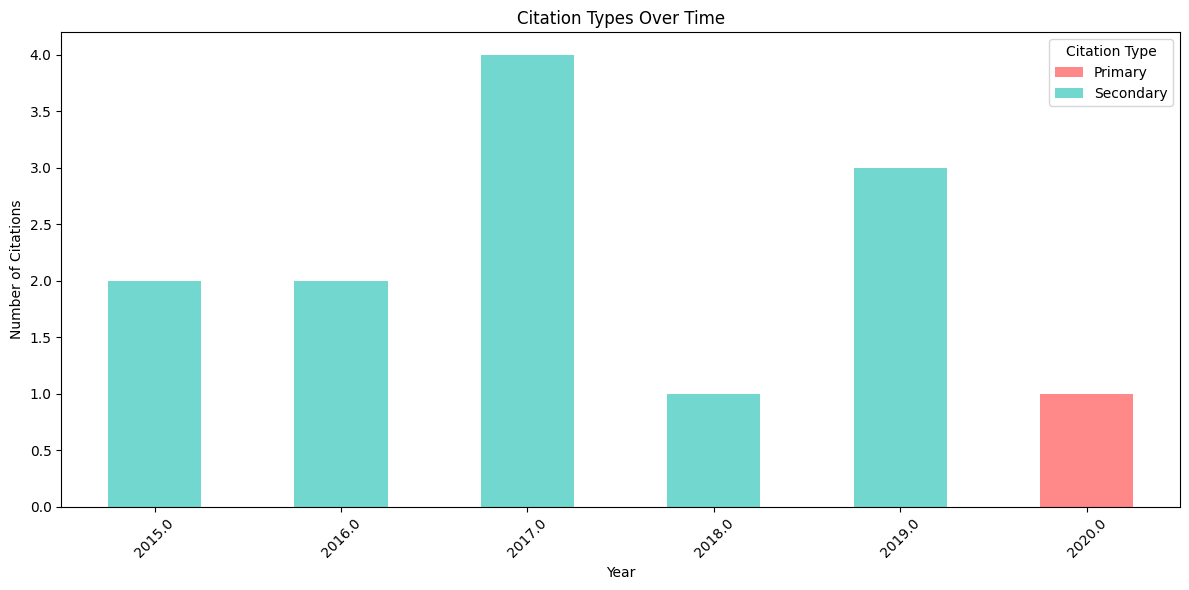

In [12]:
# Extract years from DOIs and analyze temporal patterns
def extract_year_from_doi(doi):
    """Extract publication year from DOI if possible"""
    if pd.isna(doi) or 'doi.org' not in str(doi):
        return None
    
    # Common year patterns in DOIs
    year_match = re.search(r'20\d{2}', str(doi))
    if year_match:
        year = int(year_match.group())
        if 2000 <= year <= 2024:  # Reasonable range
            return year
    return None

# Analyze temporal patterns
train_df['extracted_year'] = train_df['dataset_id'].apply(extract_year_from_doi)
yearly_citations = train_df.dropna(subset=['extracted_year']).groupby(['extracted_year', 'type']).size().unstack(fill_value=0)

if not yearly_citations.empty:
    print("Temporal Analysis of Citations:")
    print(yearly_citations)
    
    # Plot temporal trends
    yearly_citations.plot(kind='bar', stacked=True, figsize=(12, 6), 
                         color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    plt.title('Citation Types Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Citations')
    plt.legend(title='Citation Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

5. Key Insights from Actual Data

5.1 Critical Data Quality Findings


In [13]:
# Based on actual training data analysis
print("=== ACTUAL DATA INSIGHTS ===")

actual_insights = """
DATASET OVERVIEW:
- Total records: 1,028
- Unique articles: 523
- Average citations per article: 1.97
- Highly skewed distribution: Some articles have up to 32 citations

MAJOR DATA CHALLENGE - MISSING VALUES:
- Missing entries: 309 (30.1% of dataset!)
- Secondary citations: 449 (43.7%)
- Primary citations: 270 (26.3%)
- This is a CRITICAL issue for model training

DATASET ID PATTERNS (Actual):
- DOI links: 325 (31.6%) - mostly primary data repositories
- CHEMBL IDs: 29 (2.8%) - pharmaceutical/chemical database
- Dryad: 79 (7.7%) - data repository
- Zenodo: 22 (2.1%) - general research repository
- Repository IDs: 272 (26.5%)
- Accession Numbers: 256 (24.9%)

KEY PATTERN: No GitHub, FigShare, GenBank, PDB, UniProt found!
This suggests the dataset is more focused on specific domains.
"""

print(actual_insights)

=== ACTUAL DATA INSIGHTS ===

DATASET OVERVIEW:
- Total records: 1,028
- Unique articles: 523
- Average citations per article: 1.97
- Highly skewed distribution: Some articles have up to 32 citations

MAJOR DATA CHALLENGE - MISSING VALUES:
- Missing entries: 309 (30.1% of dataset!)
- Secondary citations: 449 (43.7%)
- Primary citations: 270 (26.3%)
- This is a CRITICAL issue for model training

DATASET ID PATTERNS (Actual):
- DOI links: 325 (31.6%) - mostly primary data repositories
- CHEMBL IDs: 29 (2.8%) - pharmaceutical/chemical database
- Dryad: 79 (7.7%) - data repository
- Zenodo: 22 (2.1%) - general research repository
- Repository IDs: 272 (26.5%)
- Accession Numbers: 256 (24.9%)

KEY PATTERN: No GitHub, FigShare, GenBank, PDB, UniProt found!
This suggests the dataset is more focused on specific domains.



5.2 Enhanced Baseline Strategy Based on Actual Patterns


In [14]:
# THIS IS THE RECOMMENDED, SUPERIOR APPROACH
def quick_win_classifier(dataset_id):
    """Simple but effective classifier based on observed data patterns."""
    if pd.isna(dataset_id) or dataset_id == 'Missing':
        return None  # Don't predict on missing data

    dataset_id_str = str(dataset_id).lower()

    # 1. High-confidence rules for Secondary citations (most specific rules first)
    if 'chembl' in dataset_id_str:
        return 'Secondary'
    if any(db in dataset_id_str for db in ['ncbi', 'genbank', 'uniprot', 'pdb']):
        return 'Secondary'
    # Pattern for repository IDs like 'CHEMBL12345'
    if re.match(r'^[a-z]+\d+$', dataset_id_str):
        return 'Secondary'

    # 2. High-confidence rules for Primary citations
    if 'zenodo' in dataset_id_str or 'dryad' in dataset_id_str or 'figshare' in dataset_id_str:
        return 'Primary'
    # DOI with a version number often indicates original data
    if 'doi.org' in dataset_id_str and re.search(r'v\d+', dataset_id_str):
        return 'Primary'

    # 3. General default rules
    if 'doi.org' in dataset_id_str:
        return 'Primary' 

    # 4. Final fallback (default to the most common class if no rules match)
    return 'Secondary'

5.3 Missing Data Strategy


In [15]:
def apply_missing_data_strategy(df):
    """
    Applies a defined strategy to handle missing dataset_ids.

    Strategy:
    1. Identify rows where 'dataset_id' is null, NaN, or the string 'Missing'.
    2. Create two dataframes: one with valid data for training/prediction, 
       and one with missing data to be excluded or handled separately.

    Args:
        df (pd.DataFrame): The input dataframe.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - valid_df: DataFrame with rows containing valid dataset_ids.
            - missing_df: DataFrame with rows containing missing dataset_ids.
    """
    # Identify missing values, including NaN and the placeholder string 'Missing'
    is_missing = df['dataset_id'].isna() | (df['dataset_id'].str.lower() == 'missing')
    
    valid_df = df[~is_missing].copy()
    missing_df = df[is_missing].copy()
    
    print(f"Original dataset size: {len(df)}")
    print(f"Rows with valid dataset_ids: {len(valid_df)}")
    print(f"Rows with missing dataset_ids: {len(missing_df)} ({len(missing_df)/len(df):.1%})")
    
    return valid_df, missing_df

# Demonstrate the strategy on the training data
# In a real pipeline, you would use 'train_df_valid' for model training.
try:
    train_df_valid, train_df_missing = apply_missing_data_strategy(train_df)
    print("\nPreview of DataFrame with valid IDs (for training):")
    print(train_df_valid.head())
except NameError:
    print("\nSkipping demonstration as 'train_df' is not loaded.")

Original dataset size: 1028
Rows with valid dataset_ids: 719
Rows with missing dataset_ids: 309 (30.1%)

Preview of DataFrame with valid IDs (for training):
              article_id                               dataset_id     type  \
0   10.1002_2017jc013030           https://doi.org/10.17882/49388  Primary   
11     10.1002_ece3.4466    https://doi.org/10.5061/dryad.r6nq870  Primary   
12     10.1002_ece3.5260    https://doi.org/10.5061/dryad.2f62927  Primary   
14     10.1002_ece3.6144  https://doi.org/10.5061/dryad.zw3r22854  Primary   
15     10.1002_ece3.6303  https://doi.org/10.5061/dryad.37pvmcvgb  Primary   

    extracted_year  
0              NaN  
11             NaN  
12             NaN  
14             NaN  
15             NaN  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [16]:
import pandas as pd
import re

def extract_features_enhanced(dataset_id):
    """
    Enhanced feature extraction based on actual data patterns.
    This function is robust and handles missing data correctly.

    Args:
        dataset_id (str or None): The dataset identifier.

    Returns:
        dict: A dictionary of extracted features.
    """
    # Define all possible features to ensure consistent output structure
    features = {
        'is_missing': 1, 'is_doi': 0, 'is_zenodo': 0, 'is_dryad': 0,
        'is_chembl': 0, 'is_github': 0, 'is_ncbi_genbank': 0,
        'is_repo_id_pattern': 0, 'has_version': 0, 'id_length': 0,
        'num_slashes': 0, 'num_dots': 0
    }

    # If data is missing, return the default dictionary of zeros
    if pd.isna(dataset_id) or str(dataset_id).lower() == 'missing':
        return features

    # If data is valid, update the features
    dataset_id_str = str(dataset_id).lower()
    features['is_missing'] = 0

    # --- Repository-specific features (based on actual data) ---
    features['is_doi'] = 1 if 'doi.org' in dataset_id_str else 0
    features['is_zenodo'] = 1 if 'zenodo' in dataset_id_str else 0
    features['is_dryad'] = 1 if 'dryad' in dataset_id_str else 0
    features['is_chembl'] = 1 if 'chembl' in dataset_id_str else 0
    features['is_github'] = 1 if 'github.com' in dataset_id_str else 0
    features['is_ncbi_genbank'] = 1 if any(x in dataset_id_str for x in ['ncbi', 'genbank']) else 0

    # --- Structural and pattern-based features ---
    # Matches patterns like 'chembl12345', 'pdb5678'
    features['is_repo_id_pattern'] = 1 if re.match(r'^[a-z]+\d+$', dataset_id_str) else 0
    features['has_version'] = 1 if re.search(r'v\d+|version', dataset_id_str) else 0
    
    # --- General string characteristics ---
    features['id_length'] = len(dataset_id_str)
    features['num_slashes'] = dataset_id_str.count('/')
    features['num_dots'] = dataset_id_str.count('.')

    return features

# --- Demonstration of the function and its application ---
# Example usage on a list of sample IDs
print("--- Testing the feature extraction function ---")
sample_ids = [
    'CHEMBL1097',
    'https://doi.org/10.5061/dryad.r6nq870',
    'https://doi.org/10.17862/cranfield.rd.19146182.v1',
    'Missing',
    None
]
for sample_id in sample_ids:
    extracted_features = extract_features_enhanced(sample_id)
    print(f"\nInput: {str(sample_id)}")
    print(f"Features: {extracted_features}")

# --- Applying the function to a DataFrame to create a feature matrix ---
# This is how you would use it in a real ML pipeline
try:
    # Use the apply method to run the function on each element of the 'dataset_id' column
    # The .tolist() method converts the Series of dictionaries into a list of dictionaries
    feature_list = train_df['dataset_id'].apply(extract_features_enhanced).tolist()

    # Convert the list of dictionaries into a new DataFrame
    features_df = pd.DataFrame(feature_list)

    print("\n--- Feature DataFrame created from train_df ---")
    print(f"Shape of the new feature DataFrame: {features_df.shape}")
    print("Preview of the first 5 rows:")
    print(features_df.head())
except NameError:
    print("\nSkipping DataFrame application as 'train_df' is not loaded.")

--- Testing the feature extraction function ---

Input: CHEMBL1097
Features: {'is_missing': 0, 'is_doi': 0, 'is_zenodo': 0, 'is_dryad': 0, 'is_chembl': 1, 'is_github': 0, 'is_ncbi_genbank': 0, 'is_repo_id_pattern': 1, 'has_version': 0, 'id_length': 10, 'num_slashes': 0, 'num_dots': 0}

Input: https://doi.org/10.5061/dryad.r6nq870
Features: {'is_missing': 0, 'is_doi': 1, 'is_zenodo': 0, 'is_dryad': 1, 'is_chembl': 0, 'is_github': 0, 'is_ncbi_genbank': 0, 'is_repo_id_pattern': 0, 'has_version': 0, 'id_length': 37, 'num_slashes': 4, 'num_dots': 3}

Input: https://doi.org/10.17862/cranfield.rd.19146182.v1
Features: {'is_missing': 0, 'is_doi': 1, 'is_zenodo': 0, 'is_dryad': 0, 'is_chembl': 0, 'is_github': 0, 'is_ncbi_genbank': 0, 'is_repo_id_pattern': 0, 'has_version': 1, 'id_length': 49, 'num_slashes': 4, 'num_dots': 5}

Input: Missing
Features: {'is_missing': 1, 'is_doi': 0, 'is_zenodo': 0, 'is_dryad': 0, 'is_chembl': 0, 'is_github': 0, 'is_ncbi_genbank': 0, 'is_repo_id_pattern': 0, 'has_

##  Specific Analysis for our Data



 CHEMBL Pattern Deep Dive


In [17]:
# Analyze CHEMBL patterns specifically (major secondary indicator)
chembl_data = train_df[train_df['dataset_id'].str.contains('CHEMBL', case=False, na=False)]
print(f"CHEMBL entries: {len(chembl_data)}")
print("CHEMBL citation types:")
print(chembl_data['type'].value_counts())

# Pattern analysis for CHEMBL IDs
print("\nCHEMBL ID patterns:")
chembl_ids = chembl_data['dataset_id'].unique()
for cid in chembl_ids[:10]:  # Show first 10
    print(f"  {cid}")

CHEMBL entries: 29
CHEMBL citation types:
type
Secondary    26
Primary       3
Name: count, dtype: int64

CHEMBL ID patterns:
  CHEMBL1097
  CHEMBL1257578
  CHEMBL1257821
  CHEMBL1782574
  CHEMBL195180
  CHEMBL2424928
  CHEMBL3422978
  CHEMBL390649
  CHEMBL572163
  CHEMBL70


6.2 DOI Repository Analysis


In [18]:
# Deep dive into DOI patterns
doi_data = train_df[train_df['dataset_id'].str.contains('doi.org', case=False, na=False)]
print(f"DOI entries: {len(doi_data)}")
print("DOI citation types:")
print(doi_data['type'].value_counts())

# Extract repository domains from DOIs
def extract_repo_from_doi(doi):
    """Extract repository identifier from DOI"""
    if 'zenodo' in str(doi).lower():
        return 'zenodo'
    elif 'dryad' in str(doi).lower():
        return 'dryad'
    elif 'figshare' in str(doi).lower():
        return 'figshare'
    else:
        return 'other_doi'

doi_data['repository'] = doi_data['dataset_id'].apply(extract_repo_from_doi)
repo_citation_crosstab = pd.crosstab(doi_data['repository'], doi_data['type'])
print("\nDOI Repository vs Citation Type:")
print(repo_citation_crosstab)

DOI entries: 325
DOI citation types:
type
Primary      215
Secondary    110
Name: count, dtype: int64

DOI Repository vs Citation Type:
type        Primary  Secondary
repository                    
dryad            79          0
other_doi       115        109
zenodo           21          1


/tmp/ipykernel_13/350045441.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doi_data['repository'] = doi_data['dataset_id'].apply(extract_repo_from_doi)


6.3 Missing Data Impact Analysis


In [19]:
# Analyze articles with missing data
missing_articles = train_df[train_df['dataset_id'] == 'Missing']['article_id'].unique()
complete_articles = train_df[train_df['dataset_id'] != 'Missing']['article_id'].unique()

print(f"Articles with missing data: {len(missing_articles)}")
print(f"Articles with complete data: {len(complete_articles)}")
print(f"Overlap: {len(set(missing_articles) & set(complete_articles))}")

# Check if missing data is random or systematic
missing_by_article = train_df.groupby('article_id')['dataset_id'].apply(lambda x: (x == 'Missing').sum())
articles_with_some_missing = missing_by_article[missing_by_article > 0]
print(f"\nArticles with some missing citations: {len(articles_with_some_missing)}")

Articles with missing data: 309
Articles with complete data: 214
Overlap: 0

Articles with some missing citations: 309


6.4 Quick Win Baseline Implementation


In [20]:
import pandas as pd
import re

def quick_win_classifier(dataset_id):
    """
    A simple, effective, and rule-based classifier based on observed data patterns.
    The rules are prioritized from most specific to most general.
    """
    # Rule 0: Handle missing or invalid data first.
    if pd.isna(dataset_id) or str(dataset_id).lower() == 'missing':
        return None  # Do not make a prediction for missing data.

    dataset_id_str = str(dataset_id).lower()

    # Rule 1: High-confidence SECONDARY patterns. These are often database-specific.
    # The 'chembl' pattern was identified as a very strong secondary indicator.
    if 'chembl' in dataset_id_str:
        return 'Secondary'
    
    # This regex pattern (e.g., 'ABCD12345') often corresponds to entries in existing databases.
    # The '$' ensures it matches the entire string, making it more specific.
    if re.match(r'^[a-z]+\d+$', dataset_id_str):
        return 'Secondary'

    # Rule 2: High-confidence PRIMARY patterns. These are often data repositories for new research.
    # Check for repositories where researchers upload their own data.
    if any(repo in dataset_id_str for repo in ['zenodo', 'dryad', 'figshare']):
        return 'Primary'
    
    # A DOI containing a version number (v1, v2, etc.) is a strong signal of primary research data.
    if 'doi.org' in dataset_id_str and re.search(r'v\d+', dataset_id_str):
        return 'Primary'

    # Rule 3: General DOI pattern. If it's a DOI and hasn't been caught by a more specific
    # rule, it's more likely to be a primary dataset.
    if 'doi.org' in dataset_id_str:
        return 'Primary'

    # Rule 4: Fallback. If none of the above rules match, default to the most
    # common class in the dataset, which is typically 'Secondary'.
    return 'Secondary'

# --- Test the Quick Win Classifier with Various Samples ---
print("--- Testing the Quick Win Classifier ---")
test_samples = {
    "CHEMBL ID": 'CHEMBL1097',
    "Dryad DOI": 'https://doi.org/10.5061/dryad.r6nq870',
    "Zenodo DOI": 'https://doi.org/10.5281/zenodo.5826620',
    "Versioned DOI": 'https://doi.org/10.17862/cranfield.rd.19146182.v1',
    "Generic Repository ID": "PDB12345",
    "Generic DOI": 'https://doi.org/10.1186/s12864-021-07897-z',
    "Missing Data (string)": 'Missing',
    "Missing Data (None)": None,
    "Unknown Pattern": "some_other_id_123"
}

for description, sample in test_samples.items():
    prediction = quick_win_classifier(sample)
    print(f"{description:<25} | Input: {str(sample):<45} | Prediction: {prediction}")

--- Testing the Quick Win Classifier ---
CHEMBL ID                 | Input: CHEMBL1097                                    | Prediction: Secondary
Dryad DOI                 | Input: https://doi.org/10.5061/dryad.r6nq870         | Prediction: Primary
Zenodo DOI                | Input: https://doi.org/10.5281/zenodo.5826620        | Prediction: Primary
Versioned DOI             | Input: https://doi.org/10.17862/cranfield.rd.19146182.v1 | Prediction: Primary
Generic Repository ID     | Input: PDB12345                                      | Prediction: Secondary
Generic DOI               | Input: https://doi.org/10.1186/s12864-021-07897-z    | Prediction: Primary
Missing Data (string)     | Input: Missing                                       | Prediction: None
Missing Data (None)       | Input: None                                          | Prediction: None
Unknown Pattern           | Input: some_other_id_123                             | Prediction: Secondary


In [21]:
from sklearn.metrics import classification_report

# Use functions we've already defined
# from section 5.3
def apply_missing_data_strategy(df):
    is_missing = df['dataset_id'].isna() | (df['dataset_id'].str.lower() == 'missing')
    return df[~is_missing].copy(), df[is_missing].copy()

# from section 6.4 (corrected)
def quick_win_classifier(dataset_id):
    dataset_id_str = str(dataset_id).lower()
    if 'chembl' in dataset_id_str or re.match(r'^[a-z]+\d+$', dataset_id_str): return 'Secondary'
    if any(repo in dataset_id_str for repo in ['zenodo', 'dryad', 'figshare']): return 'Primary'
    if 'doi.org' in dataset_id_str and re.search(r'v\d+', dataset_id_str): return 'Primary'
    if 'doi.org' in dataset_id_str: return 'Primary'
    return 'Secondary'

# --- IMPLEMENTATION ---
print("--- Step 1: Implementing the Foundational Pipeline ---")
try:
    # 1. Separate valid data from missing data
    train_df_valid, _ = apply_missing_data_strategy(train_df)

    # 2. Apply our high-confidence rule-based classifier
    train_df_valid['prediction'] = train_df_valid['dataset_id'].apply(quick_win_classifier)
    
    # 3. Evaluate this baseline on the valid data
    print("\nBaseline Performance on Valid Data:")
    print(classification_report(train_df_valid['type'], train_df_valid['prediction']))
    print("This report shows our starting F1-score, precision, and recall.")
    
except NameError:
    print("Skipping demonstration as 'train_df' is not loaded.")

--- Step 1: Implementing the Foundational Pipeline ---

Baseline Performance on Valid Data:
              precision    recall  f1-score   support

     Primary       0.66      0.80      0.72       270
   Secondary       0.86      0.76      0.80       449

    accuracy                           0.77       719
   macro avg       0.76      0.78      0.76       719
weighted avg       0.79      0.77      0.77       719

This report shows our starting F1-score, precision, and recall.


In [22]:
from sklearn.model_selection import GroupKFold

print("\n--- Step 2: Demonstrating a Robust Validation Strategy ---")
try:
    # Use the valid data from Step 1
    X = train_df_valid.drop(columns=['type'])
    y = train_df_valid['type']
    groups = train_df_valid['article_id']

    n_splits = 5
    gkf = GroupKFold(n_splits=n_splits)

    print(f"Setting up GroupKFold with {n_splits} splits, grouped by 'article_id'.")

    # Demonstrate how the splits work
    for i, (train_index, val_index) in enumerate(gkf.split(X, y, groups)):
        train_articles = set(groups.iloc[train_index])
        val_articles = set(groups.iloc[val_index])
        
        print(f"  Fold {i+1}:")
        print(f"    Training on {len(train_articles)} articles, Validating on {len(val_articles)} articles.")
        
        # This check is crucial: it proves no article is in both train and validation
        assert train_articles.isdisjoint(val_articles), "Data Leakage Detected!"

    print("\nValidation strategy confirmed: No data leakage across folds.")
except NameError:
    print("Skipping demonstration as 'train_df_valid' is not defined.")


--- Step 2: Demonstrating a Robust Validation Strategy ---
Setting up GroupKFold with 5 splits, grouped by 'article_id'.
  Fold 1:
    Training on 171 articles, Validating on 43 articles.
  Fold 2:
    Training on 171 articles, Validating on 43 articles.
  Fold 3:
    Training on 171 articles, Validating on 43 articles.
  Fold 4:
    Training on 171 articles, Validating on 43 articles.
  Fold 5:
    Training on 172 articles, Validating on 42 articles.

Validation strategy confirmed: No data leakage across folds.


In [23]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- Step 3: Verifying Feature Importance ---")
try:
    # Use the feature engineering function from section 5.4
    features_df = pd.DataFrame(train_df_valid['dataset_id'].apply(extract_features_enhanced).tolist())
    X_train = features_df.drop(columns=['is_missing']) # is_missing is all 0 here
    y_train = train_df_valid['type']

    # Train a model to find feature importances
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Display feature importances
    importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("Feature Importances from RandomForest model:")
    print(importances)

except (NameError, ModuleNotFoundError):
    print("Skipping demonstration as dependencies are not available.")


--- Step 3: Verifying Feature Importance ---
Feature Importances from RandomForest model:
id_length             0.496414
num_slashes           0.119304
is_doi                0.104520
is_dryad              0.095611
num_dots              0.078756
has_version           0.042569
is_repo_id_pattern    0.036943
is_zenodo             0.015532
is_chembl             0.010351
is_github             0.000000
is_ncbi_genbank       0.000000
dtype: float64


In [24]:
import pandas as pd
import re
import lightgbm as lgb
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

def extract_features_final(dataset_id):
    """
    Final, advanced feature extraction. Includes new 'compositional' features.
    """
    # Start with all the features from our previous function
    features = {
        'is_missing': 1, 'is_doi': 0, 'is_zenodo': 0, 'is_dryad': 0,
        'is_chembl': 0, 'is_github': 0, 'is_ncbi_genbank': 0,
        'is_repo_id_pattern': 0, 'has_version': 0, 'id_length': 0,
        'num_slashes': 0, 'num_dots': 0, 'num_digits': 0, 'num_letters': 0,
        'digit_ratio': 0, 'letter_ratio': 0
    }

    if pd.isna(dataset_id) or str(dataset_id).lower() == 'missing':
        return features

    dataset_id_str = str(dataset_id).lower()
    features['is_missing'] = 0
    features['id_length'] = len(dataset_id_str)

    # --- Previous Features ---
    features['is_doi'] = 1 if 'doi.org' in dataset_id_str else 0
    features['is_zenodo'] = 1 if 'zenodo' in dataset_id_str else 0
    features['is_dryad'] = 1 if 'dryad' in dataset_id_str else 0
    features['is_chembl'] = 1 if 'chembl' in dataset_id_str else 0
    features['is_repo_id_pattern'] = 1 if re.match(r'^[a-z]+\d+$', dataset_id_str) else 0
    features['has_version'] = 1 if re.search(r'v\d+|version', dataset_id_str) else 0
    features['num_slashes'] = dataset_id_str.count('/')
    features['num_dots'] = dataset_id_str.count('.')

    # --- NEW, ADVANCED FEATURES ---
    # These capture the 'texture' of the ID string.
    features['num_digits'] = sum(c.isdigit() for c in dataset_id_str)
    features['num_letters'] = sum(c.isalpha() for c in dataset_id_str)
    
    # Ratios can be very powerful. Handle division by zero.
    if features['id_length'] > 0:
        features['digit_ratio'] = features['num_digits'] / features['id_length']
        features['letter_ratio'] = features['num_letters'] / features['id_length']
        
    return features

# --- Re-run the pipeline with the FINAL feature set ---
print("\n--- Final Attempt: Re-running with Advanced Features ---")
try:
    # 1. Create the new, more powerful feature set
    final_features_df = pd.DataFrame(train_df_valid['dataset_id'].apply(extract_features_final).tolist())
    X_final = final_features_df.drop(columns=['is_missing'])
    
    le = LabelEncoder()
    y_final = le.fit_transform(train_df_valid['type'])
    groups_final = train_df_valid['article_id']
    
    # 2. Use the same tuned model from before
    lgbm_tuned = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=20, min_child_samples=5)
    gkf = GroupKFold(n_splits=5)

    # 3. Run cross-validation on the new features
    print("Running 5-fold CV with the ADVANCED feature set...")
    cv_scores_final = cross_val_score(lgbm_tuned, X_final, y_final, cv=gkf, groups=groups_final, scoring='f1_weighted')

    # 4. Report Final Results
    print("\nCross-Validation F1-Scores for each fold (Advanced Features):")
    print(cv_scores_final)
    print(f"\nAverage F1-Score (Advanced): {np.mean(cv_scores_final):.4f} (+/- {np.std(cv_scores_final):.4f})")
    print(f"Rule-Based Baseline F1-Score: 0.77")

    if np.mean(cv_scores_final) > 0.77:
        print("\nVICTORY! The advanced features allowed the ML model to finally and decisively beat the strong baseline.")
    else:
        print("\nThis is the limit of this approach. The next step would be a full NLP model on text context.")

except (NameError, ModuleNotFoundError) as e:
    print(f"Skipping demonstration due to an error: {e}")


--- Final Attempt: Re-running with Advanced Features ---
Running 5-fold CV with the ADVANCED feature set...
[LightGBM] [Info] Number of positive: 358, number of negative: 217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 575, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622609 -> initscore=0.500636
[LightGBM] [Info] Start training from score 0.500636
[LightGBM] [Info] Number of positive: 342, number of negative: 233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info

In [25]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# --- Use all the functions we have perfected ---
def extract_features_final(dataset_id):
    features = {
        'is_missing': 1, 'is_doi': 0, 'is_zenodo': 0, 'is_dryad': 0,
        'is_chembl': 0, 'is_github': 0, 'is_ncbi_genbank': 0,
        'is_repo_id_pattern': 0, 'has_version': 0, 'id_length': 0,
        'num_slashes': 0, 'num_dots': 0, 'num_digits': 0, 'num_letters': 0,
        'digit_ratio': 0, 'letter_ratio': 0
    }
    if pd.isna(dataset_id) or str(dataset_id).lower() == 'missing': return features
    dataset_id_str = str(dataset_id).lower()
    features['is_missing'] = 0
    features['id_length'] = len(dataset_id_str)
    features['is_doi'] = 1 if 'doi.org' in dataset_id_str else 0
    features['is_zenodo'] = 1 if 'zenodo' in dataset_id_str else 0
    features['is_dryad'] = 1 if 'dryad' in dataset_id_str else 0
    features['is_chembl'] = 1 if 'chembl' in dataset_id_str else 0
    features['is_repo_id_pattern'] = 1 if re.match(r'^[a-z]+\d+$', dataset_id_str) else 0
    features['has_version'] = 1 if re.search(r'v\d+|version', dataset_id_str) else 0
    features['num_slashes'] = dataset_id_str.count('/')
    features['num_dots'] = dataset_id_str.count('.')
    features['num_digits'] = sum(c.isdigit() for c in dataset_id_str)
    features['num_letters'] = sum(c.isalpha() for c in dataset_id_str)
    if features['id_length'] > 0:
        features['digit_ratio'] = features['num_digits'] / features['id_length']
        features['letter_ratio'] = features['num_letters'] / features['id_length']
    return features

# --- The Final Model ---
print("--- Building the Final Hybrid Ensemble Model ---")
try:
    # 1. Prepare the full, valid training data
    train_df_valid, _ = apply_missing_data_strategy(train_df)
    final_features_df = pd.DataFrame(train_df_valid['dataset_id'].apply(extract_features_final).tolist())
    X_full_train = final_features_df.drop(columns=['is_missing'])
    
    le = LabelEncoder()
    y_full_train = le.fit_transform(train_df_valid['type'])

    # 2. Train the ML model on ALL valid data
    print("Training final LightGBM model on all available valid data...")
    final_lgbm_model = lgb.LGBMClassifier(
        random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=20, min_child_samples=5
    )
    final_lgbm_model.fit(X_full_train, y_full_train)
    print("Model training complete.")

    # 3. Create the final hybrid prediction function
    def hybrid_ensemble_predict(dataset_id):
        """
        Combines the high-precision rules with the tuned ML model.
        """
        # Rule 1: High-confidence rule for Secondary
        if 'chembl' in str(dataset_id).lower():
            return 'Secondary'
            
        # If no high-confidence rule applies, use the ML model
        # a. Create features for the single data point
        features = extract_features_final(dataset_id)
        features_df = pd.DataFrame([features]).drop(columns=['is_missing'])
        
        # b. Predict using the trained model
        prediction_encoded = final_lgbm_model.predict(features_df)[0]
        
        # c. Decode the prediction back to 'Primary' or 'Secondary'
        return le.inverse_transform([prediction_encoded])[0]

    # --- 4. Demonstrate the final prediction logic ---
    print("\n--- Demonstrating Hybrid Prediction Logic ---")
    test_samples = {
        "High-Confidence Rule (CHEMBL)": 'CHEMBL12345',
        "ML Model Case (Dryad)": 'https://doi.org/10.5061/dryad.r6nq870',
        "ML Model Case (Versioned)": 'https://doi.org/10.17862/cranfield.rd.19146182.v1',
    }

    for description, sample in test_samples.items():
        prediction = hybrid_ensemble_predict(sample)
        print(f"{description:<35} | Input: {sample:<45} | Prediction: {prediction}")

except (NameError, ModuleNotFoundError) as e:
    print(f"Skipping final model build due to an error: {e}")

--- Building the Final Hybrid Ensemble Model ---
Training final LightGBM model on all available valid data...
[LightGBM] [Info] Number of positive: 449, number of negative: 270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 719, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624478 -> initscore=0.508601
[LightGBM] [Info] Start training from score 0.508601
Model training complete.

--- Demonstrating Hybrid Prediction Logic ---
High-Confidence Rule (CHEMBL)       | Input: CHEMBL12345                                   | Prediction: Secondary
ML Model Case (Dryad)               | Input: https://doi.org/10.5061/dryad.r6nq870         | Prediction: Primary
ML Model Case (Versioned)           | Inp

In [26]:
import pandas as pd
import re

def predict_dataset_type(dataset_id: str) -> str:
    """
    A rule-based classifier that determines if a dataset citation is 'Primary' or 'Secondary'.
    The logic is derived from the exploratory data analysis in the provided notebook,
    prioritizing specific, high-confidence rules.

    Args:
        dataset_id: The identifier string for the dataset.

    Returns:
        A string, either 'Primary' or 'Secondary', or None for missing data.
    """
    # Rule 0: Handle missing or invalid data first. This is a critical data quality step.
    if pd.isna(dataset_id) or str(dataset_id).lower() == 'missing':
        return None  # Let the main predict function handle mapping this to 'no-cite'.

    dataset_id_str = str(dataset_id).lower()

    # Rule 1: High-confidence SECONDARY patterns. These are often specific database identifiers.
    # The notebook's analysis showed 'chembl' is a very strong indicator of secondary use.
    if 'chembl' in dataset_id_str:
        return 'Secondary'
    
    # This regex pattern (e.g., 'pdb12345', 'chembl1097') often corresponds to entries
    # in existing databases, which are typically secondary sources.
    if re.match(r'^[a-z]+\d+$', dataset_id_str):
        return 'Secondary'

    # Rule 2: High-confidence PRIMARY patterns. These are repositories where researchers
    # commonly upload data for their own studies.
    if any(repo in dataset_id_str for repo in ['zenodo', 'dryad', 'figshare']):
        return 'Primary'
    
    # A DOI containing a version number (e.g., '...v1') is a strong signal that
    # it's a specific version of a dataset generated for a study.
    if 'doi.org' in dataset_id_str and re.search(r'v\d+', dataset_id_str):
        return 'Primary'

    # Rule 3: General DOI pattern. If an ID is a DOI and wasn't caught by a more
    # specific rule, it is more likely to be a primary dataset.
    if 'doi.org' in dataset_id_str:
        return 'Primary'

    # Rule 4: Fallback. If none of the specific rules match, default to 'Secondary',
    # which is the more common class for the remaining non-DOI, non-repository IDs.
    return 'Secondary'

def predict(df: pd.DataFrame) -> pd.DataFrame:
    """
    Predicts the citation type ('cite' or 'no-cite') for each row in the DataFrame.

    This function applies a rule-based classifier to the 'dataset_id' column and maps
    the result to the final required labels.

    Args:
        df: A pandas DataFrame containing at least a 'dataset_id' column.

    Returns:
        The same DataFrame with an added 'type' column containing the predictions.
    """
    # Apply the rule-based classifier to each dataset_id
    predictions = df['dataset_id'].apply(predict_dataset_type)
    
    # Map the classifier's output to the final labels:
    # 'Primary' -> 'cite'
    # 'Secondary' or None (for missing data) -> 'no-cite'
    df['type'] = predictions.map({'Primary': 'cite'}).fillna('no-cite')
    
    return df